In [17]:
import re
import nltk
nltk.download('punkt') # tokenization
nltk.download('stopwords')
from nltk.stem import PorterStemmer

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import seaborn as sns

import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lekansoyewo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lekansoyewo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Citation Reminder 
# When using the IMDB Movie Review Dataset (or any portion of it), please cite the following ACL 2011 paper:
# https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.bib 

data = pd.read_csv('./data/sample_reviews.csv')
data.head()

,review,sentiment
0,I was looking forward to seeing Bruce Willis i...,negative
1,Bugs Bunny accidentally ends up at the South P...,negative
2,I find it difficult to comprehend what makes v...,negative
3,It's been said several times - not least by me...,negative
4,New rule. Nobody is allowed to make any more Z...,negative


In [14]:
def preprocess_text(review):
    review = review.lower()
    #remove punctuation
    review = re.sub(r'[^\w\s]', '', review)
    #tokenize
    words = nltk.word_tokenize(review)
    #removing stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    #stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

In [15]:
data['review'] = data['review'].apply(preprocess_text)

In [23]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(data['review'])

In [24]:
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [16]:
#training bayes nb model
model = MultinomialNB()
model.fit(X_train, y_train)

#training svm (linear kernel model)
svm_model_linear = SVC(kernel='linear')
svm_model_linear.fit(X_train, y_train)

#training svm (rbf kernel model)
svm_model_rbf = SVC(kernel='rbf')
svm_model_rbf.fit(X_train,y_train)

SVC()

In [17]:
#training svm (rbf kernel model) via GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}  
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("SVM Accuracy after Tuning:", accuracy_tuned) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time= 5.0min
[CV] END .....................................C=0.1, gamma=1; total time= 5.1min
[CV] END .....................................C=0.1, gamma=1; total time= 5.1min
[CV] END .....................................C=0.1, gamma=1; total time= 5.0min
[CV] END .....................................C=0.1, gamma=1; total time= 5.0min
[CV] END ...................................C=0.1, gamma=0.1; total time= 5.6min
[CV] END ...................................C=0.1, gamma=0.1; total time= 5.4min
[CV] END ...................................C=0.1, gamma=0.1; total time= 5.0min
[CV] END ...................................C=0.1, gamma=0.1; total time= 5.1min
[CV] END ...................................C=0.1, gamma=0.1; total time= 5.1min
[CV] END ..................................C=0.1, gamma=0.01; total time= 5.1min
[CV] END ..................................C=0.1

In [19]:
#using svm linear model and printing accuracy scored
y_pred_svm = svm_model_linear.predict(X_test)
accuracy_svm_linear = accuracy_score(y_test, y_pred_svm)
print("SVM Linear Accuracy:", str(accuracy_svm_linear) + "\n")

#using svm rbf kernel model and printing accuracy scored
y_pred_svm_rbf = svm_model_rbf.predict(X_test)
accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
print("SVM RBF Accuracy:", str(accuracy_svm_rbf) + '\n')

#using bayes nb model and printing confusion matrix
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("BAYES NB Model Accuracy:", str(accuracy) + '\n')


SVM Linear Accuracy: 0.898

SVM RBF Accuracy: 0.8857

BAYES NB Model Accuracy: 0.8796333333333334

Confusion Matrix:
 [[13412  1577]
 [ 2034 12977]]


In [14]:
#best model is svm model linear as opposed to the gridsearchcv svm rbf due to ease of deployment and running time
best_model = svm_model_linear
joblib.dump(best_model, './models/sentiment_analysis_model.pkl') 


['./models/sentiment_analysis_model.pkl']

**Exploring Sentiment Distribution**

Let's visualize the balance (or imbalance) between positive and negative reviews within our dataset. This distribution can impact model performance and give us clues about potential biases.

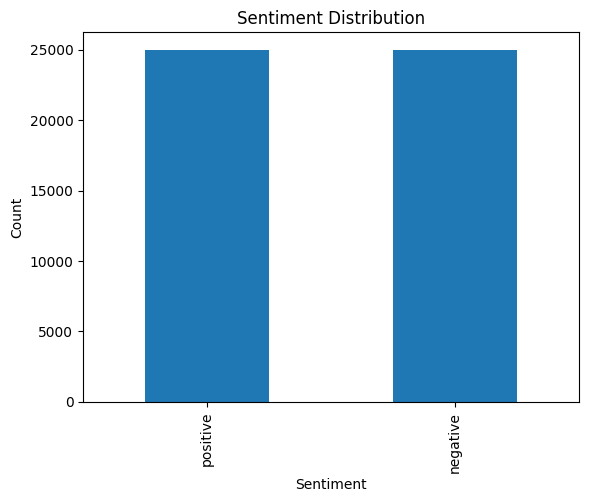

In [19]:
# 1. Distribution of Sentiments
data['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

**Word Clouds: Visualizing Sentiment-Specific Language**

Word clouds offer a visually striking way to understand the words most frequently associated with positive and negative reviews. Larger words indicate higher prominence within the sentiment class.

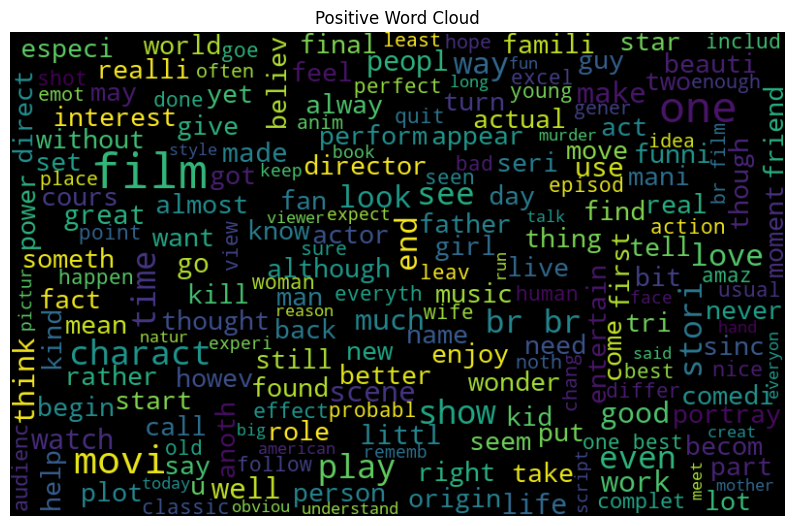

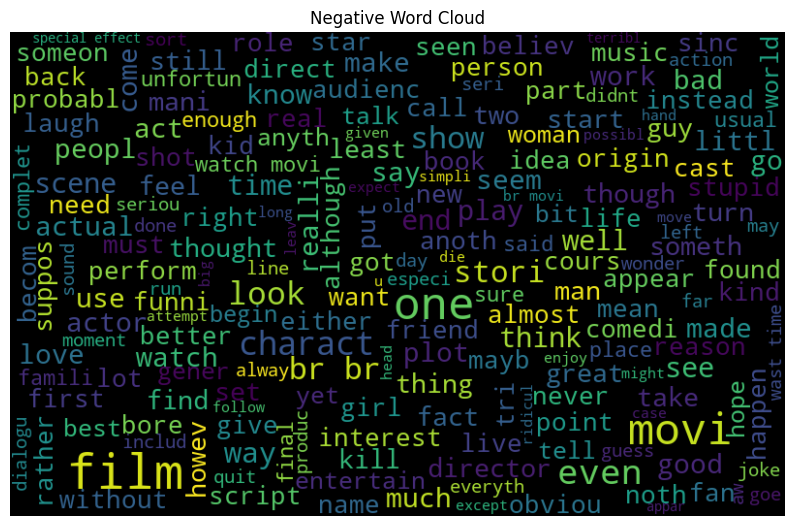

In [21]:
# 2. Word Clouds
positive_reviews = data[data['sentiment'] == 'positive']['review']
negative_reviews = data[data['sentiment'] == 'negative']['review']

def generate_wordcloud(data, title):
    all_words = ' '.join([text for text in data])
    wordcloud = WordCloud(width=800, height=500, max_font_size=50).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
generate_wordcloud(positive_reviews, "Positive Word Cloud")
generate_wordcloud(negative_reviews, "Negative Word Cloud")
